# Guia para hacer un modelo de ia del examen


## Ejercicio 1: Limpiar los datos



### QUITANDO FILAS Y COLUMNAS Y NORMALIZANDO DATOS

Para normalizar los datos hay que tener en cuenta que:
    
    Discretos/Enumerados/Cualitativos -> OneHotEncoding o Labled Encoder
        OneHotEncoding -> por defecto, si dudas usa este
        LabledEncoder -> si los valores tienen un orden

    Continuos -> StandardScaling, para normalizarlos y llevarlos a una escala comun



    -> solo deberia hacer falta copiar este codigo y cambiar las columnas en ATRIBUTOS, en final_data salen todos los datos sin el atributo solucion y en labeled_data el solucion

In [ ]:
# imports
import glob as glob
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


# ---------------------------- / LECTURA DE DATOS / ----------------------------------
data = pd.read_csv("dementia_dataset.csv") 

# TRUCO PRO: Antes de rellenar las listas de abajo, haz un print(data.info()) 
# y un print(data.describe(include='all')) en una celda aparte para ver qué columnas hay.



# ---------------- / DIAGNÓSTICO INICIAL / -------------------
print("--- INFO ---")
print(data.info())
print("\n--- NULOS POR COLUMNA ---")
print(data.isnull().sum()) # ¡ESTO ES CRUCIAL!
# Si ves una columna con 50% de nulos -> A la lista 'unnecessary_columns'
# Si ves una columna con 5% de nulos -> Imputar (media) o Borrar filas


# --------------- / ATRIBUTOS / ---------------------
# 1.1 Columnas a ELIMINAR (Drop)
unnecessary_columns = [
    "Subject ID", 
    "MRI ID", 
    "Hand"          ## Si todos son 'R' (Right), bórrala porque varianza = 0 (no aporta info).
    ]
# 1.2 Columnas a CODIFICAR con One Hot Encoding (OHE). Texto que no es la solución y no tiene jerarquía (ej: Género, Color).
oneHot_columns = [
    "M/F"
    ]
# 1.3 Columnas a ESCALAR con Standard Scaling (SS). Números que no son la solución.
#Normalizar ayuda a que el modelo converja antes y que variables grandes no dominen.
standardScaling_columns = [
    "Age",
    "EDUC",
    "SES",
    "MMSE",
    "CDR",
    "eTIV",
    "nWBV",
    "ASF",
    "Visit",        #
    "MR Delay"
]
# 1.4 La Solución (Label Encoding)
# CRITERIO: La columna que quieres predecir (Target).
labeled_columns = [
    "Group"
    ]  
solucion = "Group" # como es la única columna en labeled_columns, la ponemos aquí solita



# ---------------- / DROP /  -------------------
# Borramos lo que no sirve para limpiar el ruido del dataset.
final_data = data.drop(columns=unnecessary_columns) 
# ----------------------------------------------------------------------



# ---------------- / OHE /  -------------------
# sparse_output=False es CLAVE para que devuelva un array normal y no una matriz dispersa comprimida.
encoder = OneHotEncoder(sparse_output=False) 
encoder_final = encoder.fit_transform(data[oneHot_columns])  
# Creamos un DF temporal con nombres bonitos (ej: "M/F_M", "M/F_F")
oneHot_df = pd.DataFrame(encoder_final, columns=encoder.get_feature_names_out(oneHot_columns))
# ----------------------------------------------------------------------



# ---------------- / SS /  -------------------
# Transforma los datos para que tengan media 0 y desviación típica 1 (Curva de Gauss).
scaler = StandardScaler()
scaler_final = scaler.fit_transform(data[standardScaling_columns])
df_sc = pd.DataFrame(scaler_final, columns=standardScaling_columns, index=data.index)
# ----------------------------------------------------------------------



# ----------------- / LABELED ENCODER / -------------------------   
# Convierte "Demented" -> 0, "Nondemented" -> 1, etc.
labler = LabelEncoder()
labeled_final = labler.fit_transform(data[labeled_columns]) # .ravel() a veces evita warnings
df_lbl = pd.DataFrame(labeled_final, columns=labeled_columns, index=data.index)
# ----------------------------------------------------------------------


# ---------------- / CONCATENAR TODO / -------------------
# 1. Juntamos las 3 partes: Numéricos Escalados + Categóricos OHE + Solución Codificada
final_data = pd.concat([df_sc, oneHot_df, df_lbl], axis=1) #axis=1 significa "pegar columnas a la derecha"

# 2. Gestión de Nulos (NaN)
    # OPCIÓN A : Borrar filas con huecos.
    # Úsalo si tienes muchos datos (>1000) y pocos huecos.
final_data = final_data.dropna(how="any")

    # OPCIÓN B (Alternativa si tienes pocos datos): IMPUTAR
    # Si ves que al hacer dropna te quedas con muy pocas filas, usa esto antes de escalar:
# data['SES'] = data['SES'].fillna(data['SES'].mean()) # Imputa la media en los huecos de SES (ejemplo numérico)
 
# ---------------- / SEPARAR X (DATOS) e Y (SOLUCIÓN) / -------------------
labeled_data = final_data[solucion]
final_data = final_data.drop(columns=[solucion]) 


# ---------------- / OPCIONAL / -------------------
# Opcional: prints para verificar
# print("Tamaño final del dataset:", final_data.shape)
# para guardarlas en un archivo (opcional)
# final_data.to_csv("./examen_limpio.csv", index=False)


c:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Slices en Python (resumen rapido)

In [10]:
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
start = 0
stop = 2
step = 1

a[start:stop]  # items start through stop-1
a[start:]      # items start through the rest of the array
a[:stop]       # items from the beginning through stop-1
a[:]           # a copy of the whole array

# ---------------------------------------------

a[start:stop:step] # start through not past stop, by step

# ---------------------------------------------

a[-1]    # last item in the array
a[-2:]   # last two items in the array
a[:-2]   # everything except the last two items

# ---------------------------------------------

a[::-1]    # all items in the array, reversed
a[1::-1]   # the first two items, reversed
a[:-3:-1]  # the last two items, reversed
a[-3::-1]  # everything except the last two items, reversed


[7, 6, 5, 4, 3, 2, 1, 0]

## Ejercicio 2: Representar los datos
(WIP)


Varianza explicada: 0.46


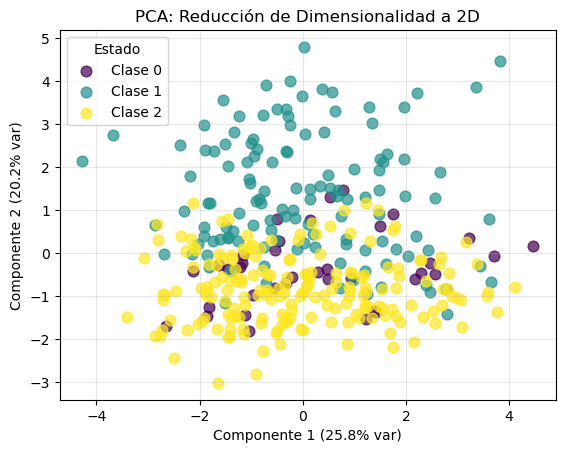

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# -------------------- / PREPARACIÓN / -------------------
x = final_data
y = labeled_data      # Esto suele ser 0, 1, 2 (codificado)
clase = solucion      # El nombre de la columna (ej: "Group")

color = y  #codificando cada action como un color



# ---------------- / DISTRIBUCIÓN DE CLASES / -------------------
# Úsalo si piden "Ver distribución de clases" o "Balanceo del dataset"
import matplotlib.pyplot as plt
import seaborn as sns # Si te dejan usar seaborn, queda más bonito

plt.figure(figsize=(6, 4))
# Opción A: Matplotlib puro
final_data[solucion].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title(f"Distribución de la variable objetivo: {solucion}")
plt.xlabel("Clases")
plt.ylabel("Cantidad de pacientes")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Opción B: Seaborn (Más profesional)
# sns.countplot(x=solucion, data=data)
# plt.show()


# ------------------- / PCA (Reducción) / ------------------------ 
pca_comp = PCA(n_components=2)
x_pca = pca_comp.fit_transform(x)

# Imprimir esto queda muy PRO en el examen: dice cuánta info mantienes
print(f"Varianza explicada: {pca_comp.explained_variance_ratio_.sum():.2f}") 

df_pca = pd.DataFrame({
    "c1": x_pca[:, 0],    # Componente Principal 1
    "c2": x_pca[:, 1],    # Componente Principal 2
    clase: y
})

grupos = sorted(df_pca[clase].unique())

# ---------------------------- / PINTADO / ------------------------ 
# Colores: Usamos un mapa de colores automático
colormap = plt.get_cmap("viridis")
colors = colormap(np.linspace(0, 1, len(grupos)))

for i, g in enumerate(grupos):
    subset = df_pca[df_pca[clase] == g]
    
    # TRUCO EXAMEN: Si tienes el 'labler' del ejercicio anterior, 
    # usa labler.inverse_transform([g])[0] para que en la leyenda ponga 
    # "Demented" en vez de "0". Si no, pon f"Clase {g}"
    
    etiqueta = f"Clase {g}" 
    # Si tienes el labler descomenta esto:
    # etiqueta = labler.inverse_transform([g])[0] 
    
    plt.scatter(
        subset["c1"], 
        subset["c2"],
        color=colors[i],    # 'color' es más seguro que 'c' para evitar warnings
        alpha=0.7,
        label=etiqueta,     # ¡FUNDAMENTAL! Para que salga en la leyenda
        s=60                # Tamaño de los puntos (opcional, queda mejor)
    )

# --- LO QUE FALTABA EN TU GUÍA ---
plt.legend(title="Estado")              # Muestra qué es cada color
plt.title("PCA: Reducción de Dimensionalidad a 2D")
plt.xlabel(f"Componente 1 ({pca_comp.explained_variance_ratio_[0]*100:.1f}% var)") # Eje X
plt.ylabel(f"Componente 2 ({pca_comp.explained_variance_ratio_[1]*100:.1f}% var)") # Eje Y
plt.grid(True, alpha=0.3)               # Cuadrícula para ver mejor las distancias

plt.show()

## Ejercicio 3: MLP

In [50]:
import MLP_Complete as mlp
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = final_data.values
y = labeled_data.values

# separa los datos 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# codificamos la 'solucion' (de labeled a ohe)
y_train = y_train.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)

Iteration      1: Cost   2.0169   
Iteration    101: Cost   1.6673   
Iteration    201: Cost   1.6602   
Iteration    301: Cost   1.1340   
Iteration    401: Cost   0.6116   
Iteration    501: Cost   0.5946   
Iteration    601: Cost   0.5769   
Iteration    701: Cost   0.5559   
Iteration    801: Cost   0.5336   
Iteration    901: Cost   0.5098   
Iteration   1001: Cost   0.4803   
Iteration   1101: Cost   0.4454   
Iteration   1201: Cost   0.4155   
Iteration   1301: Cost   0.3959   
Iteration   1401: Cost   0.4136   
Iteration   1501: Cost   0.3841   
Iteration   1601: Cost   0.3748   
Iteration   1701: Cost   0.3661   
Iteration   1801: Cost   0.3563   
Iteration   1901: Cost   0.3453   
Iteration   2000: Cost   0.3337   
-> Validacion Custom MLP: 85.39%


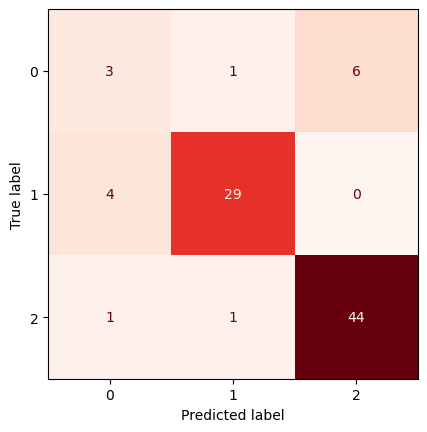

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# valores que vamos tocando
LAYERS=(128, 64, 32)
LAMBDA=0.001
LR_INIT=0.5
ITERATIONS=2000

# mlp
mlp_custom = mlp.MLP_Complete(inputLayer=X_train.shape[1], 
                              hiddenLayers=list(LAYERS), 
                              outputLayer=y_train_encoded.shape[1], 
                              seed=42)

mlp_custom.backpropagation(X_train, 
                        y_train_encoded, 
                        alpha=LR_INIT, 
                        lambda_=LAMBDA, 
                        numIte=ITERATIONS, 
                        verbose=100)

a, z = mlp_custom.feedforward(X_test)
y_pred = mlp_custom.predict(a[-1])
    


# resultados
acc_custom = accuracy_score(y_test, y_pred)
print(f"-> Validacion Custom MLP: {acc_custom * 100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Reds", colorbar=False)


## Ejercicio 4: Otros modelos

### MLP

   | pros | cons | 
   |---|---|
   | tolerancia a ruido | caja negra |
   | lineal y no lineal | costoso |
   | escalable | --- |


In [21]:
from sklearn.neural_network import MLPClassifier

# codigo del mlp de sklearn

# valores que vamos tocando
LAYERS=(62, 70)
LAMBDA=0.001
LR_INIT=0.5
ITERATIONS=10000

mlp_sklearn = MLPClassifier(
        hidden_layer_sizes=LAYERS,
        activation='logistic',     
        solver='sgd',             
        max_iter=ITERATIONS,
        learning_rate="constant",
        learning_rate_init=LR_INIT,
        alpha=LAMBDA,             
        random_state=42,
        n_iter_no_change=100,
        verbose=True
    )

mlp_sklearn.fit(X_train, y_train)

y_pred_sklearn = mlp_sklearn.predict(X_test)

acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"-> Validacion SKLearn MLP: {acc_sklearn * 100:.2f}%")

c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.32073173
Iteration 2, loss = 3.96235383
Iteration 3, loss = 1.06117503
Iteration 4, loss = 0.95524426
Iteration 5, loss = 0.92094986
Iteration 6, loss = 0.91462271
Iteration 7, loss = 0.91362414
Iteration 8, loss = 0.90979727
Iteration 9, loss = 0.89987311
Iteration 10, loss = 0.88481297
Iteration 11, loss = 0.86890031
Iteration 12, loss = 0.85230531
Iteration 13, loss = 0.82924883
Iteration 14, loss = 0.79212821
Iteration 15, loss = 0.74353883
Iteration 16, loss = 0.68592702
Iteration 17, loss = 0.62014524
Iteration 18, loss = 0.55900670
Iteration 19, loss = 0.50809611
Iteration 20, loss = 0.46957015
Iteration 21, loss = 0.42800797
Iteration 22, loss = 0.39524042
Iteration 23, loss = 0.36952226
Iteration 24, loss = 0.34923137
Iteration 25, loss = 0.33342985
Iteration 26, loss = 0.32230274
Iteration 27, loss = 0.31337895
Iteration 28, loss = 0.30889045
Iteration 29, loss = 0.30471847
Iteration 30, loss = 0.30065784
Iteration 31, loss = 0.29839316
Iteration 32, los

### KNN

   | pros | cons | 
   |---|---|
   | caja blanca | sensible a irrelevancias y ruido |
   | entrenamiento rapido | ejecucion lenta |
   | tolerancia a la forma de los datos | costoso en memoria |

In [52]:
from sklearn.neighbors import KNeighborsClassifier

# codigo del KNN

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"-> Validacion KNN: {acc_knn * 100:.2f}%")

-> Validacion KNN: 82.02%


c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Decision Tree


   | pros | cons | 
   |---|---|
   | caja blanca | sensible al ruido |
   | entrenamiento rapido | simple |
   | agradecido con los datos | tiende al overfitting si no hay limite de profunidad |

In [22]:
from sklearn.tree import DecisionTreeClassifier

# codigo del decision tree

dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"-> Validacion DT: {acc_dt * 100:.2f}%")

-> Validacion DT: 80.90%


### Random Forest

   | pros | cons | 
   |---|---|
   | facil de calcular | caja gris (blanca por el dt, negra por la votacion) |
   | valora la relevancia de los datos | sensible al ruido, tiende al overfitting |

In [24]:
from sklearn.ensemble import RandomForestClassifier


# codigo del random forest

rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"-> Validacion RF: {acc_rf * 100:.2f}%")

-> Validacion RF: 89.89%


c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Ejercicio 5: Metricas

Accuracy o Precisión (tasa de exactitud): 
$\Large\frac{TP+TN}{TP+N+FP+FN} = \frac{V}{F}$

Recall (ratio de positivos reales): $\Large\frac{TP}{TP+FN}$

Precision (ratio de clasificaciones correctas) : $\Large\frac{TP}{TP+FP}$


   | ↓ Datos predichos | Positive Observed | Negative Observed | ← Datos reales |
   |---|---|---|---|
   | Positive Predicted | TP | FP | Precision |
   | Negative Predicted | FP | TN |   |
   | ↑ Datos predichos | Recall |  | |

F1Score: $\Large\frac{Precision*Recall}{Precision+Recall}$

Mide el equilibrio entre el Recall y el Precision entre 0 y 1, 1 seria un clasificador perfecto

-> Accuracy/Precisión Custom MLP: 85.39%
-> Recall Custom MLP: 85.39%
-> Precision Custom MLP: 73.02%
-> F1 Score Custom MLP: 71.88%


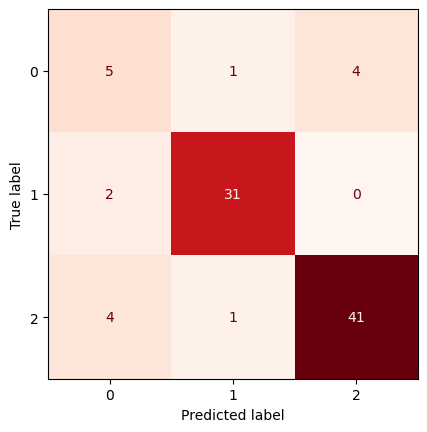

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Matriz de confusion (con una)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sklearn, cmap="Reds", colorbar=False)

# ACCURACY
acc_custom = accuracy_score(y_test, y_pred)
print(f"-> Accuracy/Precisión Custom MLP: {acc_custom * 100:.2f}%")

# RECALL
recall_custom = recall_score(y_test, y_pred, average='micro')
print(f"-> Recall Custom MLP: {recall_custom * 100:.2f}%")

# PRECISION
prec_custom = precision_score(y_test, y_pred, average='macro')
print(f"-> Precision Custom MLP: {prec_custom * 100:.2f}%")

# F1 Score
f1_custom = f1_score(y_test, y_pred, average='macro')
print(f"-> F1 Score Custom MLP: {f1_custom * 100:.2f}%")

Text(0.5, 1.0, 'SKLearn\nAcc: 80.90%')

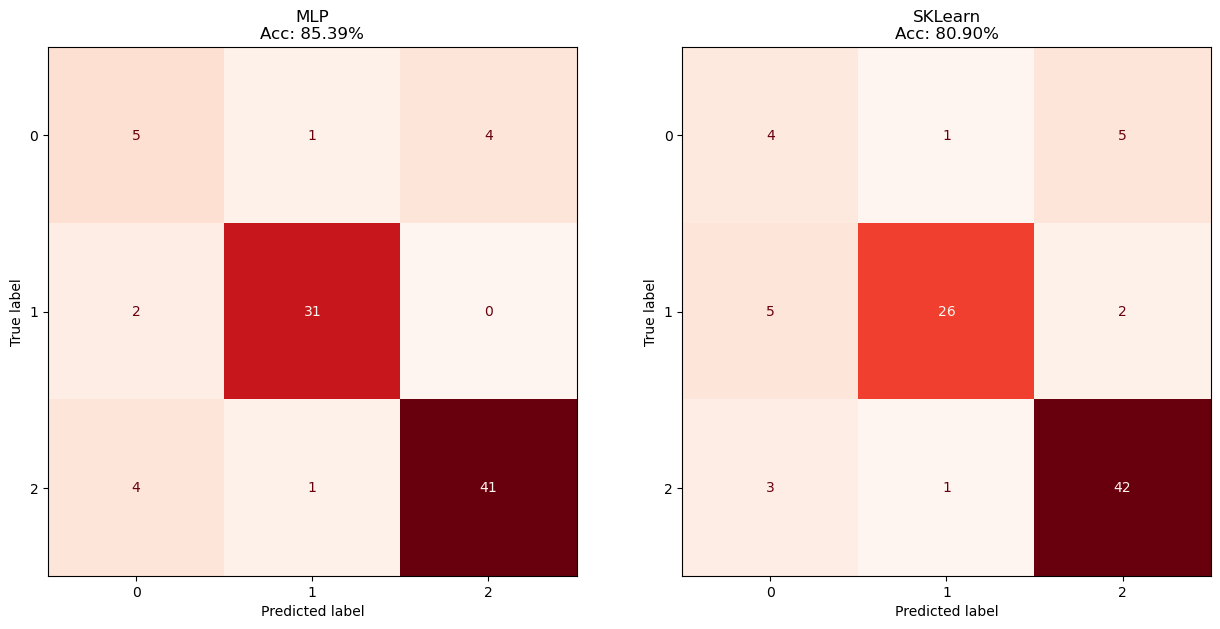

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusion (con varias)
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes = axes.flatten()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sklearn, ax=axes[0], cmap="Reds", colorbar=False)
axes[0].set_title(f"MLP\nAcc: {acc_custom * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=axes[1], cmap="Reds", colorbar=False)
axes[1].set_title(f"SKLearn\nAcc: {acc_dt * 100:.2f}%")

### DIAGNOSTICO

   | (coste) | validacion baja | validacion alta | 
   |---|---|---|
   | entrenamiento bajo | precision alta (lo que queremos) | overfitting (overfitting, tmb se puede ir subiendo lambda con cuidado) |
   | entrenamiento alto | datos de validacion sesgados (modelo mal) | modelo mal |